In [23]:
%%capture
!pip install pandas nltk scipy matplotlib openpyxl

In [24]:
suffix: str = "gemma2_9b"

In [25]:
single_call_path: str = f"../resources/{suffix}/sampled_reviews_with_output_{suffix}.csv"
multi_call_path: str = f"../resources/{suffix}/sampled_reviews_with_output_multicall_{suffix}.csv"

In [26]:
import pandas as pd
import re
import json

single_call_dataframe: pd.DataFrame = pd.read_csv(single_call_path)
multi_call_dataframe: pd.DataFrame = pd.read_csv(multi_call_path)

In [27]:
single_call_dataframe.head(5)

,review,sentiment,entities,json,progressive_index,output,json_output
0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""1s..."
1,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""Fo..."
2,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""Bu..."
3,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""A ..."
4,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""On..."


In [28]:
multi_call_dataframe.head(5)

,review,sentiment,entities,json,progressive_index,output,json_output
0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""1s..."
1,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""Fo..."
2,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""Bu..."
3,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""A ..."
4,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""On..."


In [29]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoothing_function: SmoothingFunction = SmoothingFunction()

ZERO_SCORE = ({
                  "review_score": .0,
                  "sentiment_score": .0,
                  "ner_score": {
                      "accuracy": .0,
                      "precision": .0,
                      "recall": .0,
                      "f1": .0
                  }
              }, .0)


def compute_bleu(reference: str, hypothesis: str) -> float:
    """
    It computes the BLEU score between hypothesis and reference.

    Arguments:
        hypothesis (list[str]): The hypothesis.
        reference (list[list[str]]): The reference.

    Return:
        The BLEU score.
    """
    return corpus_bleu([[reference.split()]], [hypothesis.split() if isinstance(hypothesis, str) else hypothesis],
                       smoothing_function=smoothing_function.method1)


def parse(string: str) -> dict:
    dictionary: dict = None
    try:
        dictionary = json.loads(string)
    except Exception:
        pass
    try:
        dictionary = eval(string)
    except Exception:
        pass
    return dictionary


def evaluate(row: pd.DataFrame) -> (dict, float):
    ground_truth: dict = parse(row["json"])
    if ground_truth is None:
        return ZERO_SCORE, 0.0

    if "json_output" not in row:
        return ZERO_SCORE, 0.0

    output: str = row["json_output"]
    
    output_dict: dict = parse(output)
    if output_dict is None:
        return ZERO_SCORE, 0.0

    gt_review = ground_truth["review"] if "review" in ground_truth and isinstance(ground_truth["review"], str) else None
    out_review = output_dict["review"] if "review" in output_dict and isinstance(output_dict["review"], str) else None

    review_score: float = compute_bleu(gt_review,
                                       out_review) if gt_review is not None and out_review is not None else .0
    sentiment_score: float = 1.0 if "sentiment" in output_dict and output_dict["sentiment"] == ground_truth[
        "sentiment"] else 0.0

    ground_truth_entities: list[str] = ground_truth["entities"]
    score: dict = {
        "review_score": review_score,
        "sentiment_score": sentiment_score,
        "ner_score": {
            "accuracy": .0,
            "precision": .0,
            "recall": .0,
            "f1": .0
        }
    }
    if "entities" not in output_dict:
        return score, sum([review_score, sentiment_score, .0]) / 3.0

    detected_entities = output_dict["entities"] if "entities" in output_dict else []
    if len(detected_entities) == 0 and len(ground_truth_entities) == 0:
        score["ner_score"]["accuracy"] = 1.0
        score["ner_score"]["precision"] = 1.0
        score["ner_score"]["recall"] = 1.0
        score["ner_score"]["f1"] = 1.0
        return score, sum([review_score, sentiment_score, 1.0]) / 3.0

    false_negatives: int = 0  # Quelli che ci sono in GT, ma non nei detected
    false_positives: int = 0  # Quelli che sono stati individuati, ma non ci sono in GT
    true_positives: int = 0  # Quelli che sono stati correttamente individuati

    for ge in ground_truth_entities:
        ge_found: bool = False
        for de in detected_entities:
            if "label" not in de or "value" not in de or len(de.items()) != 2:
                continue
            label: str = de["label"]
            value: str = de["value"]
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if ge_found:
            true_positives += 1
        else:
            false_negatives += 1

    for de in detected_entities:
        if "label" not in de or "value" not in de or len(de.items()) != 2:
            false_positives += 1
            continue
        label: str = de["label"]
        value: str = de["value"]
        ge_found: bool = False
        for ge in ground_truth_entities:
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if not ge_found:
            false_positives += 1

    score["ner_score"]["accuracy"]: float = true_positives / (
            true_positives + false_positives + false_negatives) if true_positives + false_positives + false_negatives > 0 else .0
    score["ner_score"]["precision"]: float = true_positives / (
            true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["recall"]: float = true_positives / (
            true_positives + false_negatives) if true_positives + false_negatives > 0 else .0
    score["ner_score"]["f1"] = 2 * (score["ner_score"]["precision"] * score["ner_score"]["recall"]) / (
            score["ner_score"]["precision"] + score["ner_score"]["recall"]) if (score["ner_score"]["precision"] +
                                                                                score["ner_score"][
                                                                                    "recall"]) > 0 else .0

    return score, sum([review_score, sentiment_score, score["ner_score"]["f1"]]) / 3.0


In [30]:
def set_score(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe["score"] = dataframe.apply(
        lambda row: evaluate(row)[1], axis=1)
    dataframe["score_detail"] = dataframe.apply(
        lambda row: evaluate(row)[0], axis=1)
    dataframe["review_score"] = dataframe.apply(
        lambda row: row["score_detail"]["review_score"] if "review_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["sentiment_score"] = dataframe.apply(
        lambda row: row["score_detail"]["sentiment_score"] if "sentiment_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_accuracy"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["accuracy"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_precision"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["precision"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_recall"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["recall"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_f1"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["f1"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    if "level_0" in dataframe.columns:
        dataframe.drop(columns=["level_0"], inplace=True)
    if "index" in dataframe.columns:
        dataframe.drop(columns=["index"], inplace=True)
    dataframe.reset_index(inplace=True)
    return dataframe

In [31]:
multi_call_dataframe: pd.DataFrame = set_score(multi_call_dataframe)
single_call_dataframe: pd.DataFrame = set_score(single_call_dataframe)

In [32]:
multi_call_dataframe.head(5)

,index,review,sentiment,entities,json,progressive_index,output,json_output,score,score_detail,review_score,sentiment_score,ner_accuracy,ner_precision,ner_recall,ner_f1
0,0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""1s...",0.666667,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.000000,0.000000,0.000000,0.000000
1,1,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""Fo...",0.666667,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.000000,0.000000,0.000000,0.000000
2,2,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""Bu...",0.855153,"{'review_score': 0.9654578807075669, 'sentimen...",0.965458,1.0,0.428571,0.500000,0.750000,0.600000
3,3,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""A ...",0.538462,"{'review_score': 1.0, 'sentiment_score': 0.0, ...",1.000000,0.0,0.444444,0.571429,0.666667,0.615385
4,4,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""On...",0.714286,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.076923,0.125000,0.166667,0.142857


In [33]:
single_call_dataframe.head(5)

,index,review,sentiment,entities,json,progressive_index,output,json_output,score,score_detail,review_score,sentiment_score,ner_accuracy,ner_precision,ner_recall,ner_f1
0,0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""1s...",0.666667,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.000000,0.000000,0.000000,0.000000
1,1,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""Fo...",0.666667,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.000000,0.000000,0.000000,0.000000
2,2,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""Bu...",0.544042,"{'review_score': 0.9654578807075669, 'sentimen...",0.965458,0.0,0.500000,0.600000,0.750000,0.666667
3,3,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...","{\n ""sentiment"": ""negative"",\n ""review"": ""A ...",0.747840,"{'review_score': 0.9935190066267136, 'sentimen...",0.993519,1.0,0.142857,0.500000,0.166667,0.250000
4,4,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...","{\n ""sentiment"": ""positive"",\n ""review"": ""On...",0.722222,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.090909,0.166667,0.166667,0.166667


In [34]:
single_call_dataframe.to_excel(single_call_path.replace(".csv", ".xlsx"), index=False)
multi_call_dataframe.to_excel(multi_call_path.replace(".csv", ".xlsx"), index=False)

In [35]:
import matplotlib.pyplot as plt


def plot_score(score_key: str, single_call_dataframe: pd.DataFrame, multi_call_dataframe: pd.DataFrame):
    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot KDE for both datasets
    single_call_dataframe[score_key].plot(kind='kde', ax=ax, label='Single-Call', color='red')
    multi_call_dataframe[score_key].plot(kind='kde', ax=ax, label='Multi-Call', color='blue')

    # Set x and y limits
    ax.set_xlim(left=0.0, right=1.0)
    ax.set_ylim(bottom=0.0)

    # Add labels and title for the KDE plot
    capitalized = score_key.replace("_", " ").capitalize()
    ax.set_xlabel(capitalized)
    ax.set_ylabel('Density')
    ax.set_title('Density Plot Comparison')
    ax.grid(True)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"../resources/{suffix}/{suffix} - {capitalized} - evaluation.png", format='png', dpi=300)
    plt.show()

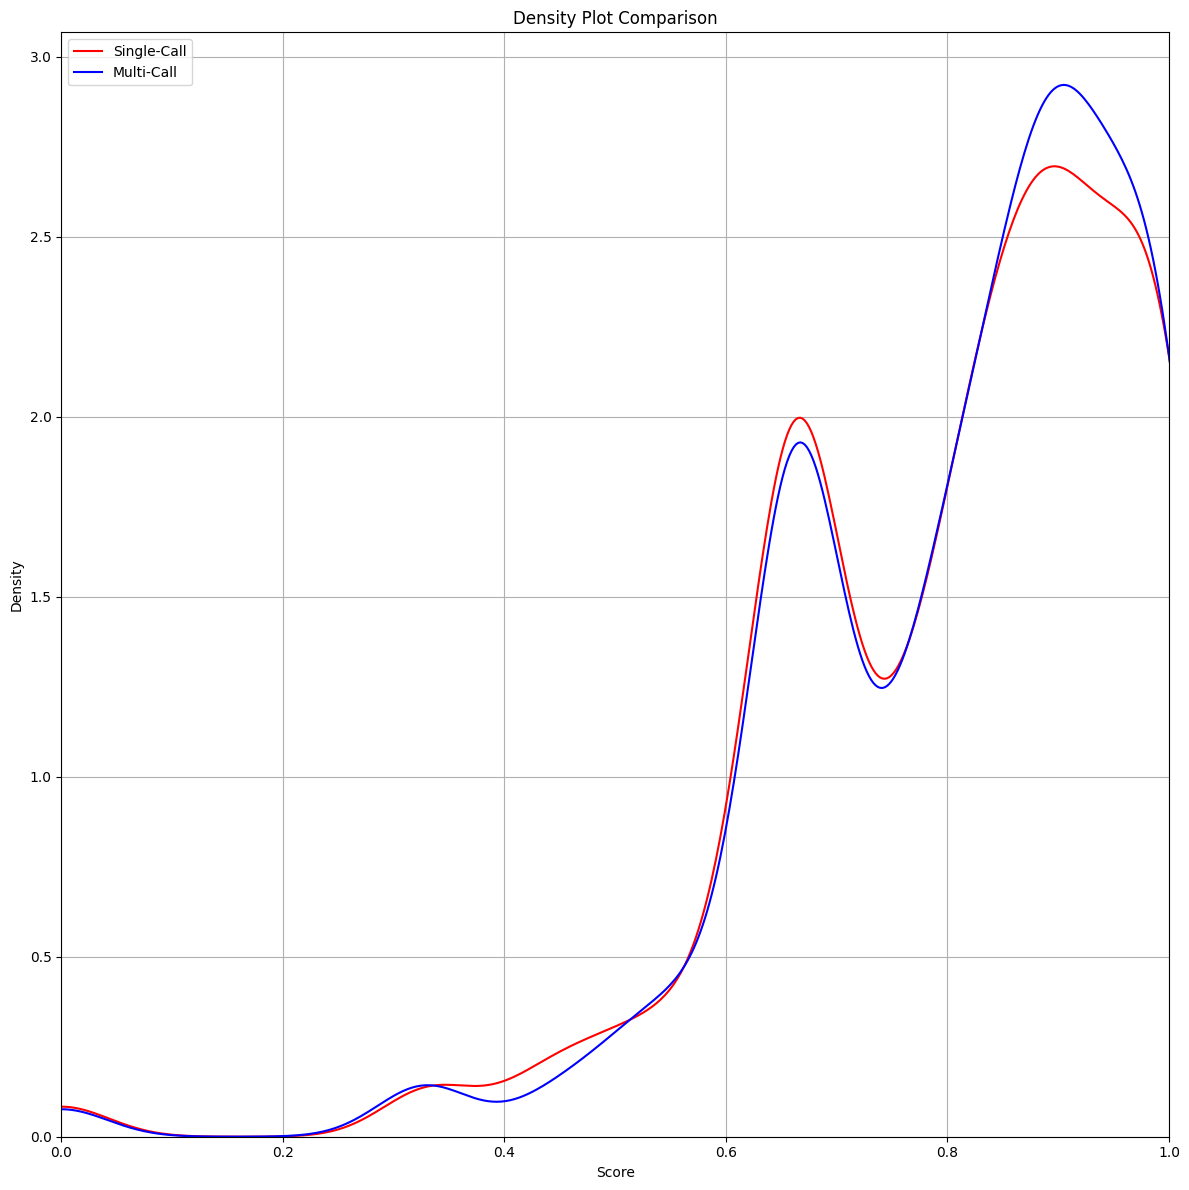

In [36]:
plot_score("score", single_call_dataframe, multi_call_dataframe)

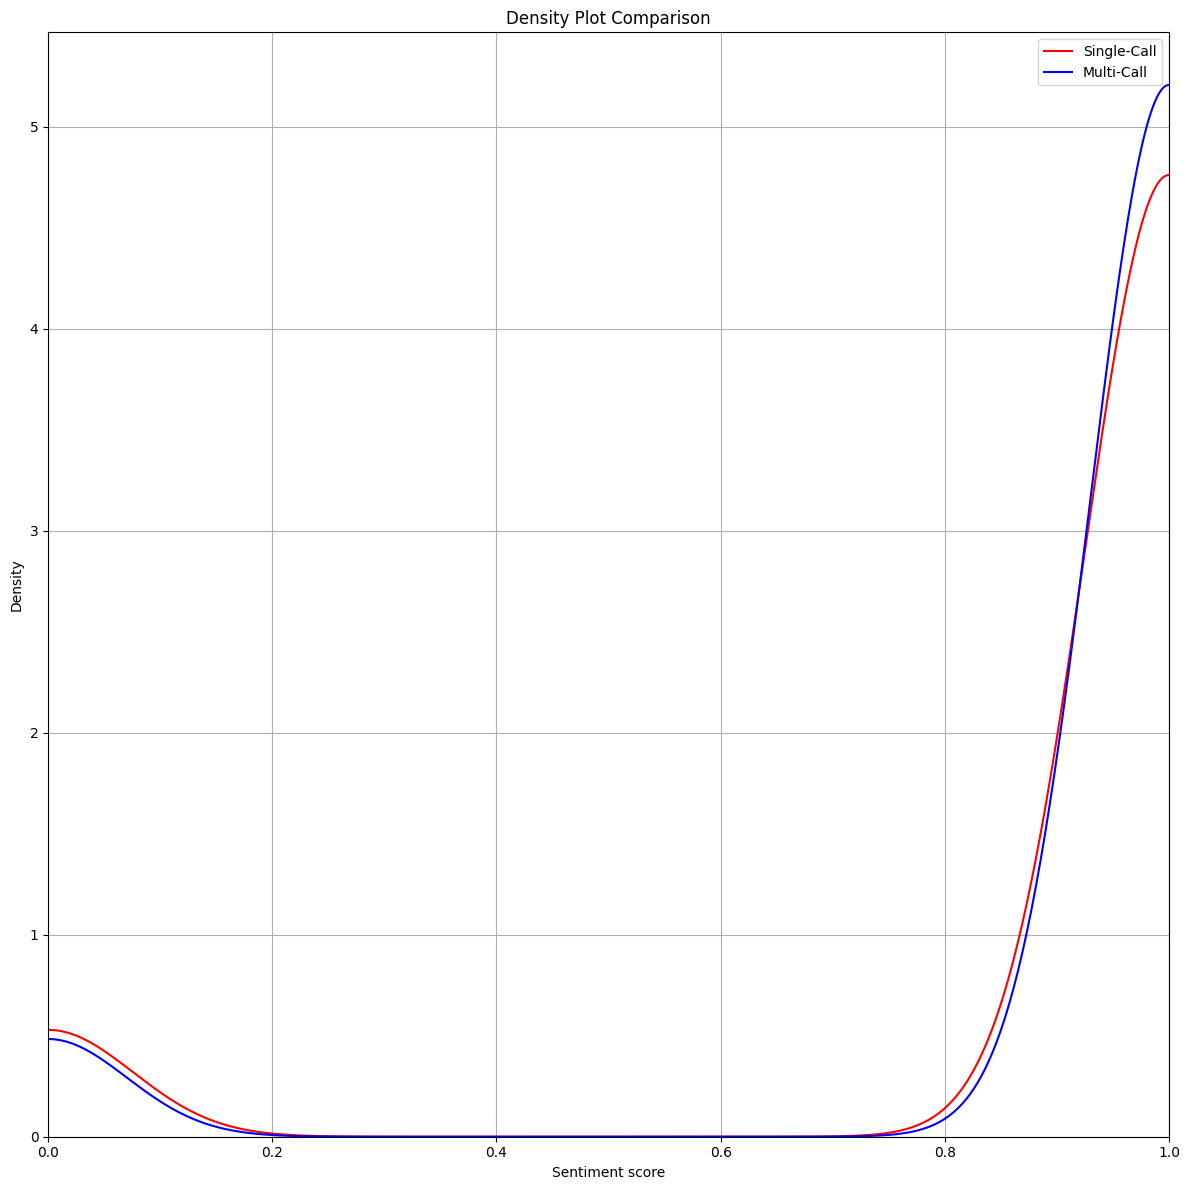

In [37]:
plot_score("sentiment_score", single_call_dataframe, multi_call_dataframe)

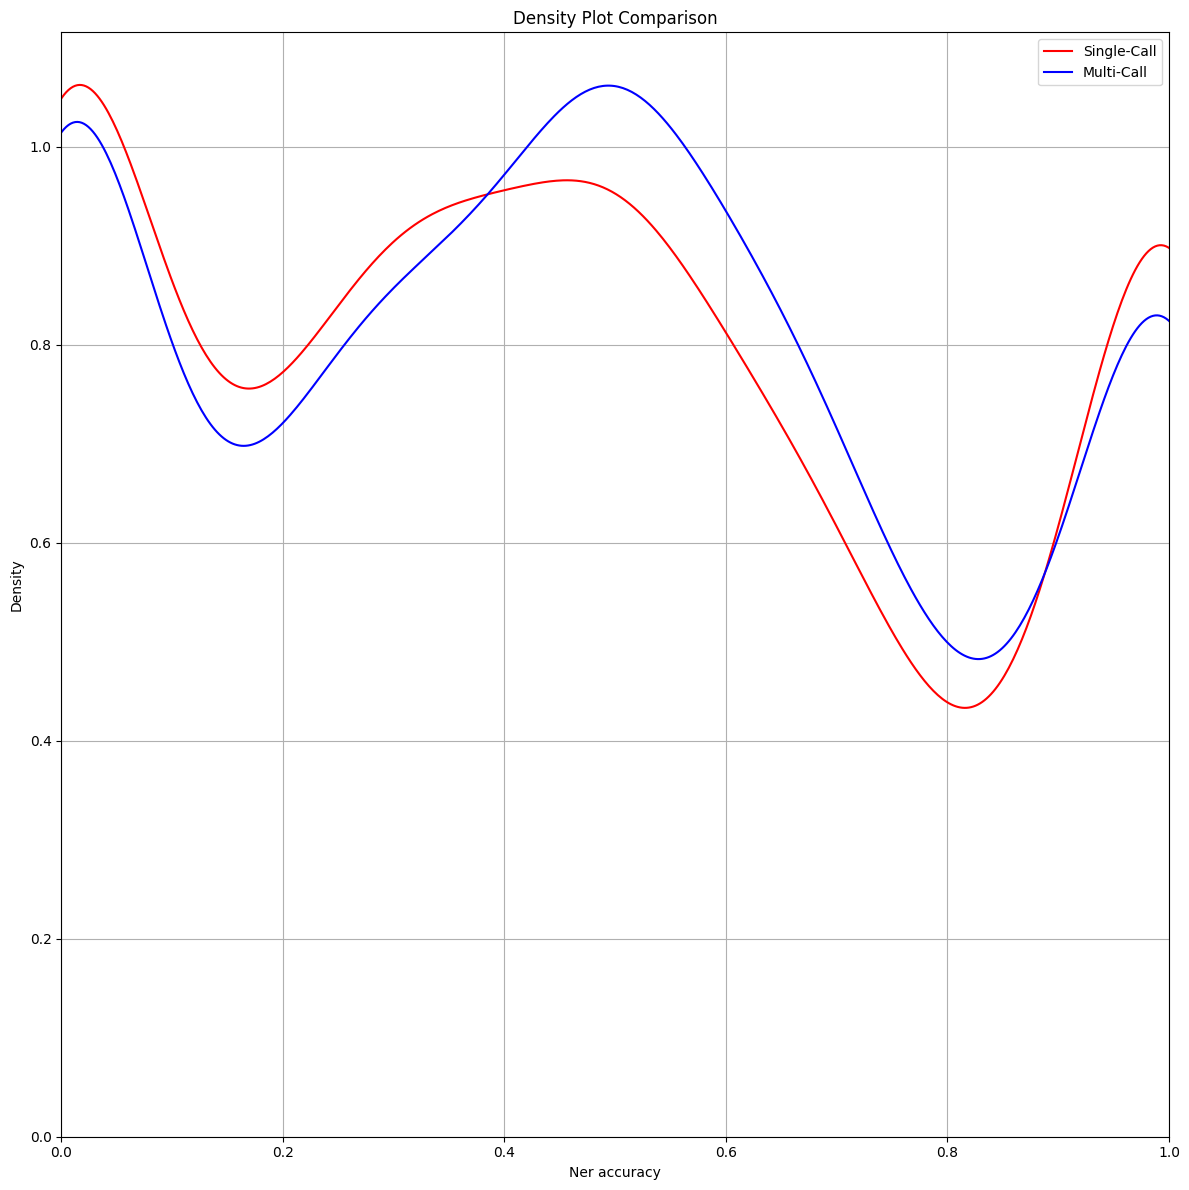

In [38]:
plot_score("ner_accuracy", single_call_dataframe, multi_call_dataframe)

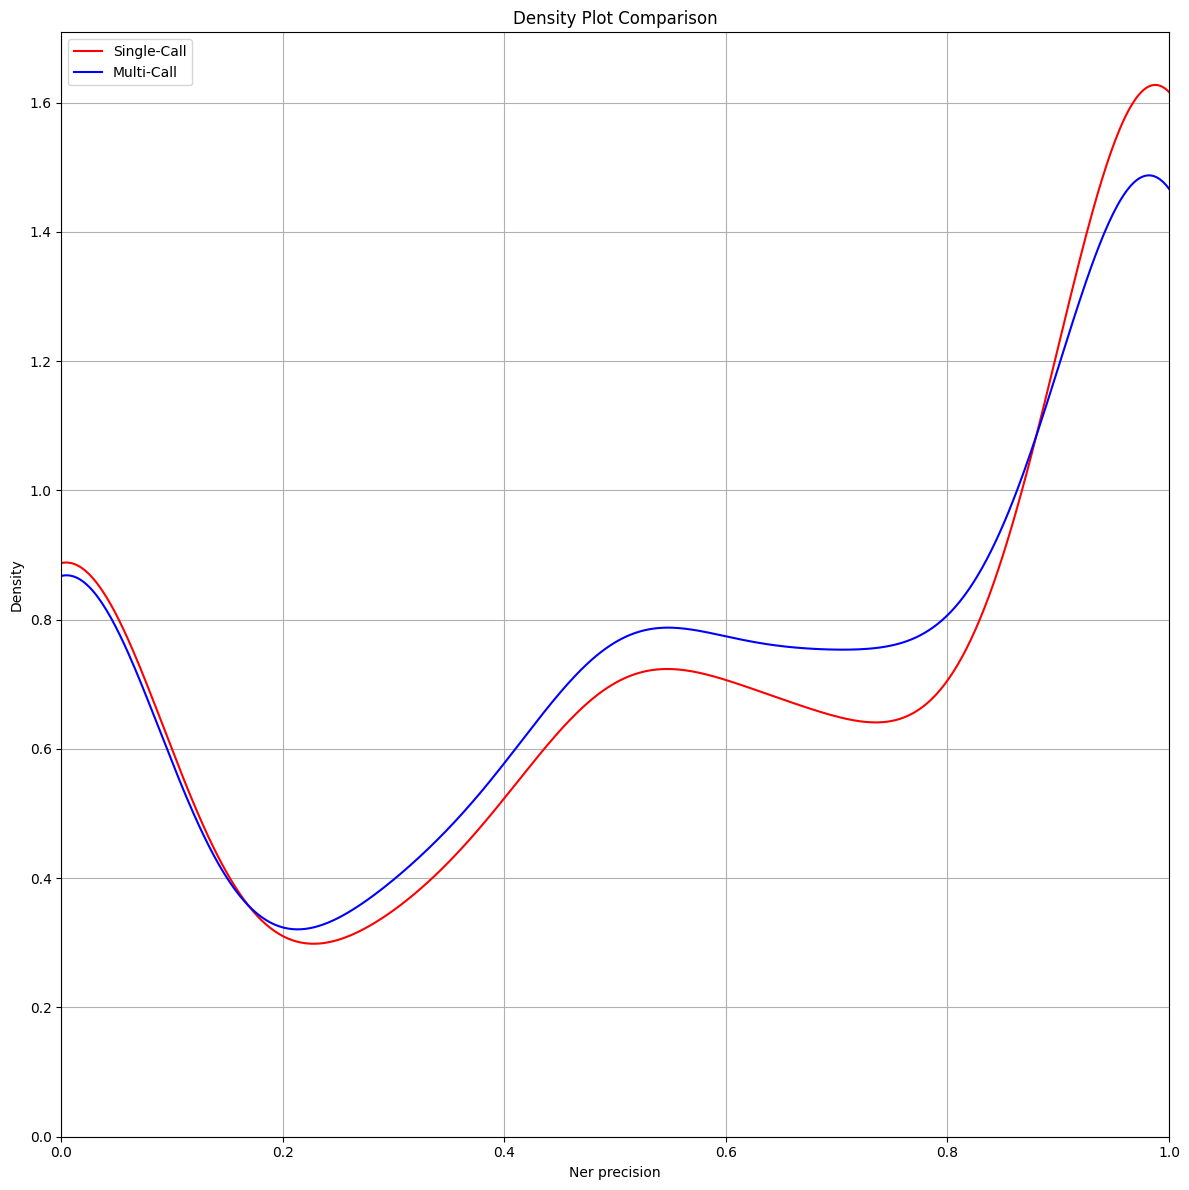

In [39]:
plot_score("ner_precision", single_call_dataframe, multi_call_dataframe)

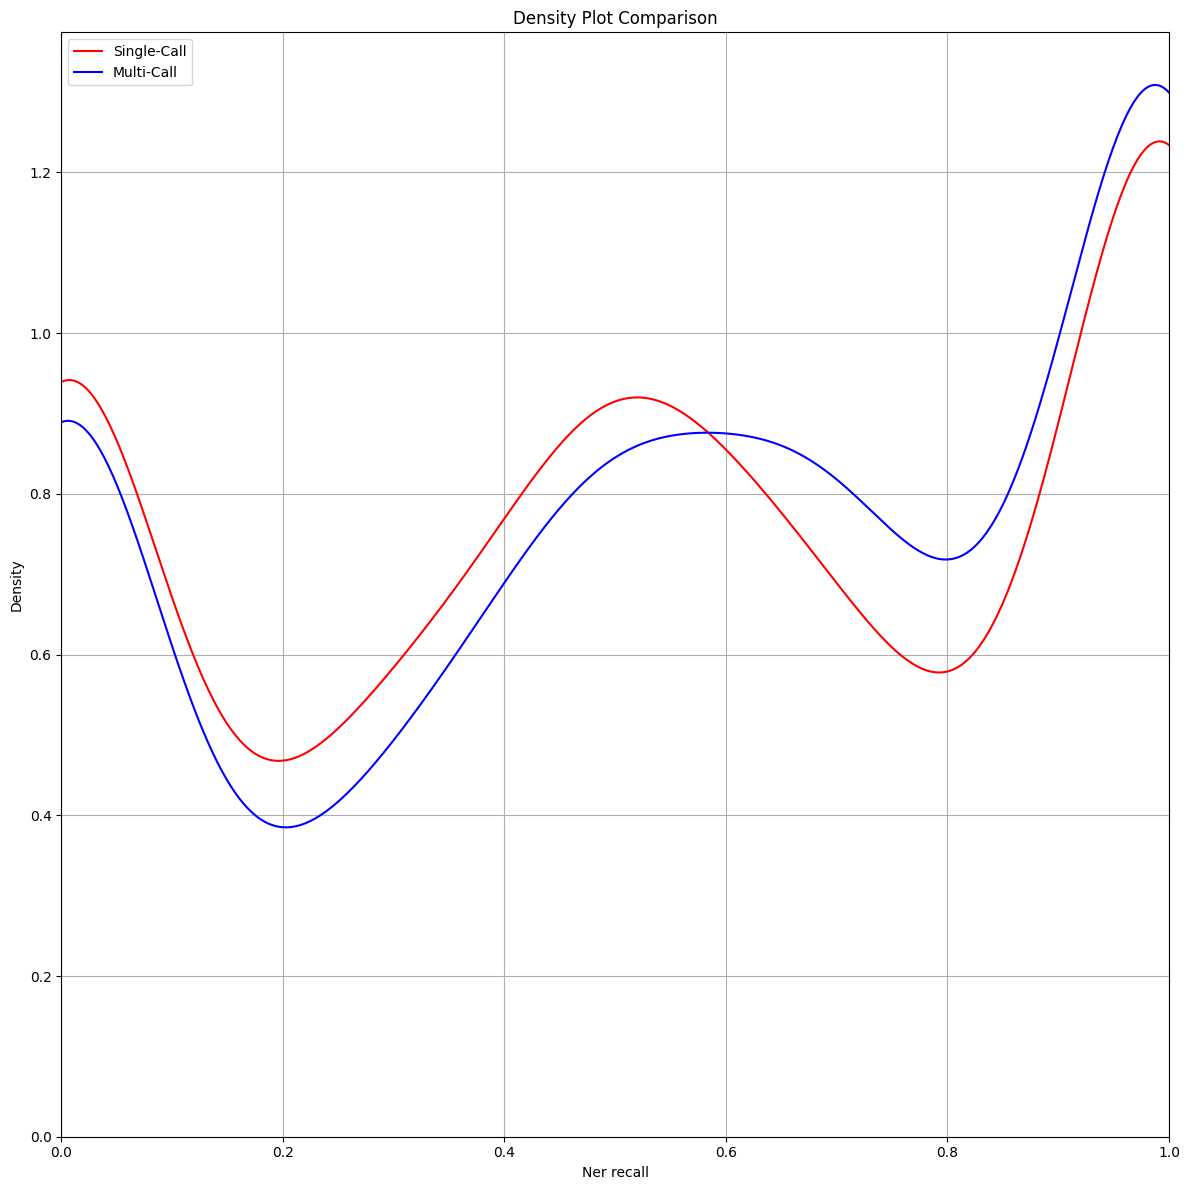

In [40]:
plot_score("ner_recall", single_call_dataframe, multi_call_dataframe)

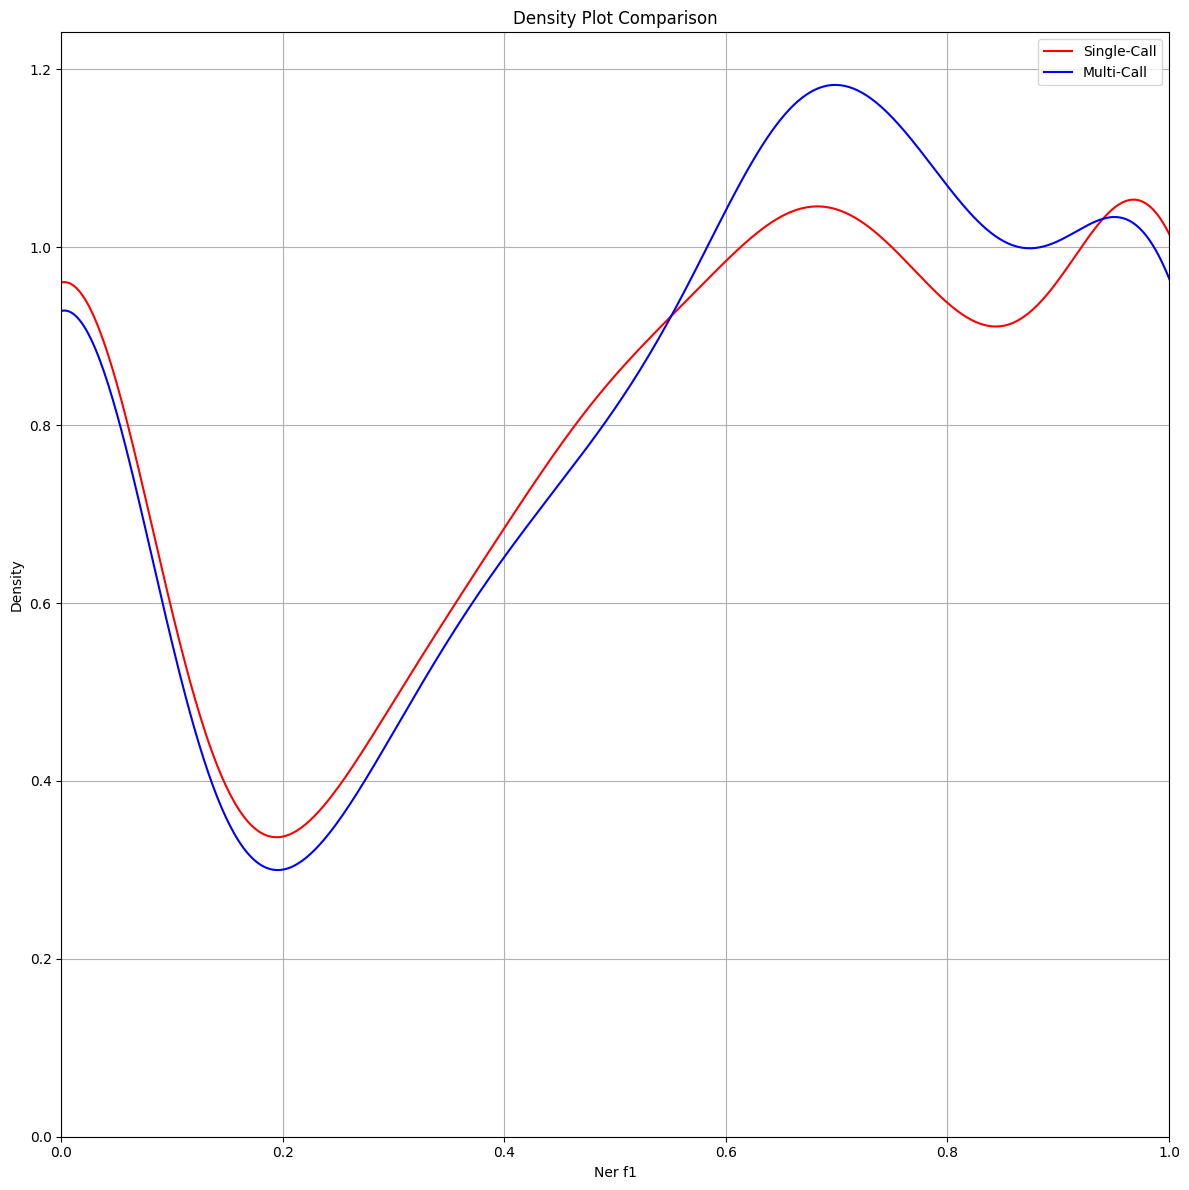

In [41]:
plot_score("ner_f1", single_call_dataframe, multi_call_dataframe)

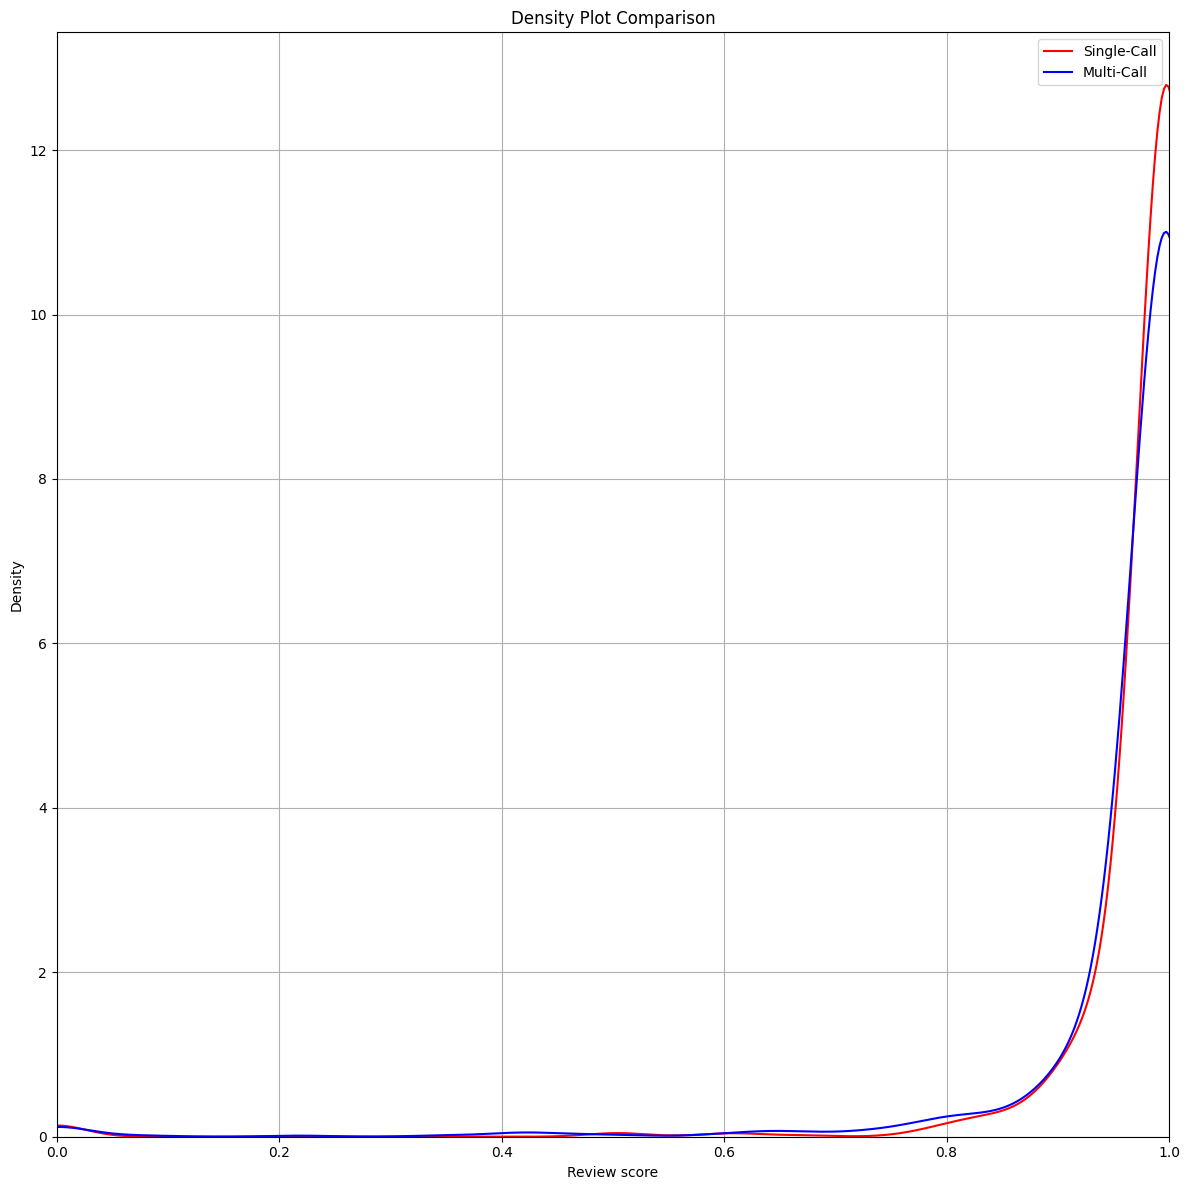

In [42]:
plot_score("review_score", single_call_dataframe, multi_call_dataframe)

In [43]:
single_call_dataframe.to_csv(single_call_path.replace(".csv", "_evaluated.csv"), index=False)

In [44]:
multi_call_dataframe.to_csv(multi_call_path.replace(".csv", "_evaluated.csv"), index=False)